## INTRODUCTION

We have assigned a task as a DS fot the telecommunications operator Megaline. The company offers two prepaid plans to its customers: Surf and Ultimate. The commercial department wants to know which plan generates more revenue in order to adjust the advertising budget. Theses Datasets come from the ___TrippleTen - Data Scientis Course___.

We are tasked with conducting a preliminary analysis of the plans based on a relatively small sample of 500 Megaline customers. We will have data for these customers, including their identities, locations, which plan they use, as well as the number of calls they made and the number of text messages they sent in 2018. Our job is to analyze customer behavior and determine which prepaid plan generates more revenue.

Important Notes on Billing:
- ___Call Duration Rounding:___ Megaline rounds each call's duration to the nearest minute. This means that even if a call lasts just one second, it will be counted as one full minute.
- ___Data Usage Rounding:___ Individual web sessions are not rounded. However, at the end of the month, the total data usage is rounded up to the nearest gigabyte. For example, if a user uses 1025 MB of data in a month, they will be billed for 2 GB.

___Request:___

- The number of calls made and minutes used per month.
- The number of SMS sent per month.
- The volume of data used per month.
- The monthly revenue for each user.

___Questions___

- What is the average number of calls made per plan? 
- What is the average number of SMS sent per plan?
- What is the average number of GB used per plan?
- What is the average number of income get per plan?



 ___Hypotesis:___

- The average revenue of users on the Ultimate and Surf plans differs.
- The average revenue of users in the New York-New Jersey area is different from that of users in other regions.

## DATA DESCRIPTION
- Users Table (Information about users):
    - user_id: Unique identifier for the user.
    - first_name: User's first name.
    - last_name: User's last name.
    - age: User's age (in years).
    - reg_date: Subscription date (dd, mm, yy).
    - churn_date: Date when the user stopped using the service (if absent, the plan was active when the data was extracted).
    - city: User's city of residence.
    - plan: Name of the plan (either "Surf" or "Ultimate").

- Calls Table (Data about calls):
    - id: Unique identifier for the call.
    - call_date: Date of the call.
    - duration: Duration of the call (in minutes).
    - user_id: Identifier of the user who made the call.

- Messages Table (Data about SMS):
    - id: Unique identifier for the SMS.
    - message_date: Date of the SMS.
    - user_id: Identifier of the user who sent the SMS.

- Internet Table (Data about web sessions):
    - id: Unique identifier for the session.
    - mb_used: Volume of data used during the session (in megabytes).
    - session_date: Date of the web session.
    - user_id: Identifier of the user.

- Plans Table (Data about the plans):
    - plan_name: Name of the plan.
    - usd_monthly_fee: Monthly fee in USD.
    - minutes_included: Included minutes per month.
    - messages_included: Included SMS per month.
    - mb_per_month_included: Included data per month (in megabytes).
    - usd_per_minute: Price per minute for exceeding the plan's included minutes.
    - usd_per_message: Price per SMS for exceeding the plan's included messages.
    - usd_per_gb: Price per GB for exceeding the plan's included data (1 GB = 1024 megabytes).


___Description of the Plans:___
1. Surf Plan:
- Monthly Fee: $20
- Included:
    - 500 minutes per month
    - 50 SMS per month
    - 15 GB of data per month
- Excess Charges (if the user exceeds the included limits):
    - 1 minute: $0.03
    - 1 SMS: $0.03
    - 1 GB of data: $10

2. Ultimate Plan:
- Monthly Fee: $70
- Included:
    - 3000 minutes per month
    - 1000 SMS per month
    - 30 GB of data per month
- Excess Charges (if the user exceeds the included limits):
    - 1 minute: $0.01
    - 1 SMS: $0.01
    - 1 GB of data: $7


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns 
from scipy import stats as st

In [2]:
#Data frames
df_calls = pd.read_csv('megaline_calls.csv')
df_internet = pd.read_csv('megaline_internet.csv')
df_messages = pd.read_csv('megaline_messages.csv')
df_plans = pd.read_csv('megaline_plans.csv')
df_users = pd.read_csv('megaline_users.csv')

In [3]:
# PLANS
print(f"Duplicate values: {df_plans.duplicated().sum()}\n")
df_plans

Duplicate values: 0



,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [4]:
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [5]:
# USERS
df_users['city'] = df_users['city'].str.upper()
print(f"Duplicate values: {df_users.duplicated().sum()}")

df_users.sample(10)

Duplicate values: 0


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
131,1131,Shane,Morrison,60,"LOS ANGELES-LONG BEACH-ANAHEIM, CA MSA",2018-01-07,surf,NaN
301,1301,Tomas,Horton,64,"CHICAGO-NAPERVILLE-ELGIN, IL-IN-WI MSA",2018-01-04,ultimate,NaN
7,1007,Eusebio,Welch,42,"GRAND RAPIDS-KENTWOOD, MI MSA",2018-07-11,surf,NaN
427,1427,Zofia,Brock,64,"WASHINGTON-ARLINGTON-ALEXANDRIA, DC-VA-MD-WV MSA",2018-01-26,ultimate,NaN
21,1021,Ricarda,Booker,37,"LOS ANGELES-LONG BEACH-ANAHEIM, CA MSA",2018-12-21,surf,NaN
430,1430,Myung,Pugh,63,"NEW YORK-NEWARK-JERSEY CITY, NY-NJ-PA MSA",2018-12-07,surf,NaN
20,1020,Rutha,Bell,56,"DALLAS-FORT WORTH-ARLINGTON, TX MSA",2018-11-08,surf,NaN
482,1482,Armand,Glenn,70,"NEW YORK-NEWARK-JERSEY CITY, NY-NJ-PA MSA",2018-01-01,ultimate,NaN
147,1147,Duncan,Malone,71,"URBAN HONOLULU, HI MSA",2018-04-30,surf,NaN
145,1145,Venice,Brooks,29,"SAN JOSE-SUNNYVALE-SANTA CLARA, CA MSA",2018-04-12,surf,NaN


In [6]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
# Calls
print(f"Duplicate values: {df_calls.duplicated().sum()}")
df_calls.sample(10)

Duplicate values: 0


,id,user_id,call_date,duration
10539,1046_405,1046,2018-08-13,0.00
127297,1456_74,1456,2018-07-12,0.00
95820,1340_170,1340,2018-08-26,4.78
19707,1075_52,1075,2018-10-16,0.21
97122,1346_352,1346,2018-10-06,9.56
87015,1320_684,1320,2018-09-30,0.00
132054,1475_201,1475,2018-11-19,4.80
92732,1334_100,1334,2018-12-31,14.44
118535,1412_819,1412,2018-09-22,23.11
122350,1432_200,1432,2018-10-31,6.90


In [8]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [9]:
# Messages
print(f"Duplicate values: {df_messages.duplicated().sum()}")
df_messages.sample(10)

Duplicate values: 0


,id,user_id,message_date
16065,1107_119,1107,2018-12-20
45682,1312_166,1312,2018-03-27
33432,1211_108,1211,2018-12-14
61976,1387_50,1387,2018-10-26
12499,1082_11,1082,2018-06-10
668,1006_657,1006,2018-12-30
48326,1324_1060,1324,2018-06-25
40652,1261_307,1261,2018-08-21
49005,1327_98,1327,2018-11-03
75079,1489_154,1489,2018-10-28


In [10]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [11]:
# Internet
print(f"Duplicate values: {df_internet.duplicated().sum()}")
df_internet.sample(10)

Duplicate values: 0


,id,user_id,session_date,mb_used
12967,1061_464,1061,2018-09-15,0.00
8204,1043_383,1043,2018-08-20,582.27
79015,1368_188,1368,2018-12-15,673.19
2927,1016_151,1016,2018-11-28,785.91
15708,1071_342,1071,2018-09-05,0.00
68704,1321_47,1321,2018-07-08,689.51
86481,1402_10,1402,2018-12-05,365.02
83151,1389_13,1389,2018-06-06,469.17
102178,1489_190,1489,2018-10-29,0.00
62486,1286_442,1286,2018-12-18,409.97


In [12]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


## PRE-PROCESSING

___Work plan___

1. Verify if there are rows with explicit or implicit values depending on the data type.
2. Remove any duplicate data from the DataFrame or split a field if need it.
3. Identify missing values and fill them as appropriate for each DataFrame.


### PLAN

In [13]:
df_plans['gb_per_month_included'] = df_plans['mb_per_month_included'] / 1024

### USERS

In [14]:
# Converting datatype to datetime
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'],format='%Y-%m-%d')

In [15]:
# Filling missing values
df_users['churn_date'].fillna('Active',inplace=True)

# Splitting reg_date field
df_users['year'] = df_users['reg_date'].dt.year
df_users['month'] = df_users['reg_date'].dt.month
df_users['day'] = df_users['reg_date'].dt.day

print(f"From year {df_users['year'].min()} to {df_users['year'].max()}")
df_users.sample(5)

From year 2018 to 2018


C:\Users\JoseC\AppData\Local\Temp\ipykernel_2332\3261045646.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_users['churn_date'].fillna('Active',inplace=True)


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,year,month,day
366,1366,Rod,Huff,62,"CINCINNATI, OH-KY-IN MSA",2018-07-30,surf,Active,2018,7,30
449,1449,Boyd,Kelley,39,"SEATTLE-TACOMA-BELLEVUE, WA MSA",2018-10-04,surf,Active,2018,10,4
295,1295,Hung,Flowers,68,"KANSAS CITY, MO-KS MSA",2018-08-11,surf,Active,2018,8,11
482,1482,Armand,Glenn,70,"NEW YORK-NEWARK-JERSEY CITY, NY-NJ-PA MSA",2018-01-01,ultimate,Active,2018,1,1
109,1109,Dominic,Salinas,41,"NEW YORK-NEWARK-JERSEY CITY, NY-NJ-PA MSA",2018-02-16,surf,Active,2018,2,16


### CALLS

In [16]:
# Converting datatype to datetime
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'],format='%Y-%m-%d')

In [17]:
# Rounding up duration field
df_calls['duration_rounded'] = np.ceil(df_calls['duration'])


# Splitting call_date field
df_calls['year'] = df_calls['call_date'].dt.year
df_calls['month'] = df_calls['call_date'].dt.month
df_calls['day'] = df_calls['call_date'].dt.day

print(f"From year {df_calls['year'].min()} to {df_calls['year'].max()}")
df_calls.sample(5)

From year 2018 to 2018


,id,user_id,call_date,duration,duration_rounded,year,month,day
18412,1071_192,1071,2018-07-22,0.00,0.0,2018,7,22
58983,1214_52,1214,2018-08-30,12.08,13.0,2018,8,30
54597,1196_487,1196,2018-06-05,10.29,11.0,2018,6,5
66386,1240_244,1240,2018-12-23,12.16,13.0,2018,12,23
103772,1365_968,1365,2018-11-26,9.38,10.0,2018,11,26


### MESSAGES

In [18]:
# Converting datatype to datetime
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'],format='%Y-%m-%d')

# Splitting message_date field 
df_messages['year'] = df_messages['message_date'].dt.year
df_messages['month'] = df_messages['message_date'].dt.month
df_messages['day'] = df_messages['message_date'].dt.day

print(f"From year {df_messages['year'].min()} to {df_messages['year'].max()}")
df_calls.sample(5)

From year 2018 to 2018


,id,user_id,call_date,duration,duration_rounded,year,month,day
48945,1176_44,1176,2018-11-13,11.00,11.0,2018,11,13
125863,1445_278,1445,2018-06-05,8.40,9.0,2018,6,5
51019,1185_57,1185,2018-07-16,2.64,3.0,2018,7,16
109121,1385_191,1385,2018-07-08,17.07,18.0,2018,7,8
87757,1321_573,1321,2018-09-21,20.59,21.0,2018,9,21


### INTERNET

In [19]:
# Converting datatype to datetime
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'],format='%Y-%m-%d')

# Converting mgb to GBs
df_internet['gb_used'] = df_internet['mb_used'] / 1024

# Splitting message_date field 
df_internet['year'] = df_internet['session_date'].dt.year
df_internet['month'] = df_internet['session_date'].dt.month
df_internet['day'] = df_internet['session_date'].dt.day

print(f"From year {df_internet['year'].min()} to {df_internet['year'].max()}")
df_internet.sample(5)

From year 2018 to 2018


,id,user_id,session_date,mb_used,gb_used,year,month,day
70276,1328_235,1328,2018-08-18,402.15,0.392725,2018,8,18
56794,1257_61,1257,2018-08-19,364.54,0.355996,2018,8,19
71503,1334_71,1334,2018-11-03,476.00,0.464844,2018,11,3
84677,1396_3,1396,2018-08-11,112.29,0.109658,2018,8,11
42135,1187_312,1187,2018-04-20,600.45,0.586377,2018,4,20


## REQUESTS

1. The number of calls made and minutes used per month.
2. The number of SMS sent per month.
3. The volume of data used per month.
4. The monthly revenue for each user.

### Calls/minutes per month

In [20]:
pivot_calls = df_calls.pivot_table(index=['user_id', 'month'],
                                    values=['duration'],
                                    aggfunc=['sum','count']).reset_index()
pivot_calls


,user_id,month,sum,count
,,,duration,duration
0,1000,12,116.83,16
1,1001,8,171.14,27
2,1001,9,297.69,49
3,1001,10,374.11,65
4,1001,11,404.59,64
...,...,...,...,...
2253,1498,12,324.77,39
2254,1499,9,330.37,41
2255,1499,10,363.28,53


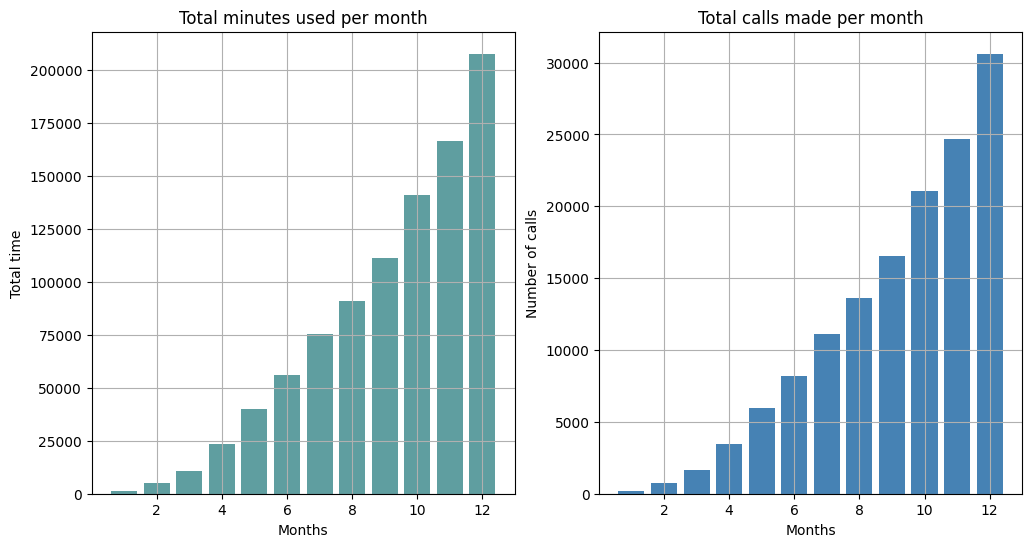

In [21]:
# Charts
calls_tduration = pivot_calls.groupby('month')['sum'].sum().reset_index()
calls_total = pivot_calls.groupby('month')['count'].sum().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Total time chart
ax1.bar(calls_tduration['month'],
        calls_tduration[('sum', 'duration')],
        color ='cadetblue'
        )
        
ax1.set_title('Total minutes used per month')
ax1.set_xlabel('Months')
ax1.set_ylabel('Total time')
ax1.grid(True)

# Total calls chart
ax2.bar(calls_total['month'],
        calls_total[('count', 'duration')],
        color = 'steelblue'
        )
ax2.set_title('Total calls made per month')
ax2.set_xlabel('Months')
ax2.set_ylabel('Number of calls')
ax2.grid(True)


Remarks

- We can see that every month the number of minutes used increases, as well as the number of calls, with December being the highest month in both cases.

### SMS sent per month

<Axes: title={'center': 'Total SMS sent per month'}, xlabel='Months', ylabel='Number of messages'>

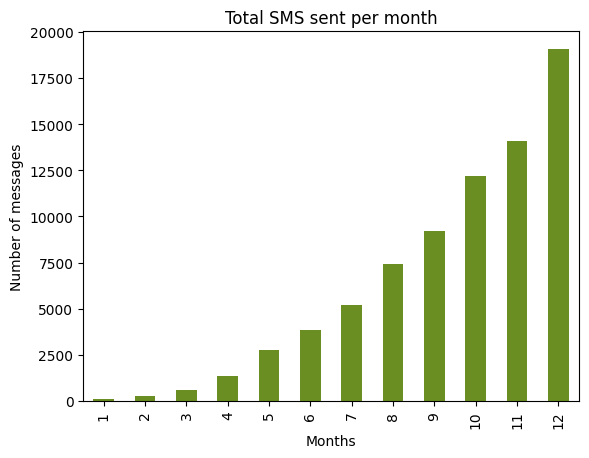

In [22]:
# Request 2
df_monthly_messages = df_messages.groupby(['user_id','month'])['id'].count().reset_index()
df_monthly_messages.rename(columns={'id':'messages'},inplace=True)
messages_total = df_monthly_messages.groupby('month')['messages'].sum().reset_index()

messages_total.plot(x='month',
                    y='messages',
                    title='Total SMS sent per month',
                    xlabel='Months',
                    ylabel='Number of messages',
                    color='olivedrab',
                    kind='bar',
                    legend=False,
                    )


Remarks

- We can see that every month the number of SMS sent increases, as well as the previous charts, with December being the highest month in both cases.

### GB used per month

<Axes: title={'center': 'Total GBs used per month'}, xlabel='Months', ylabel='Gigabytes'>

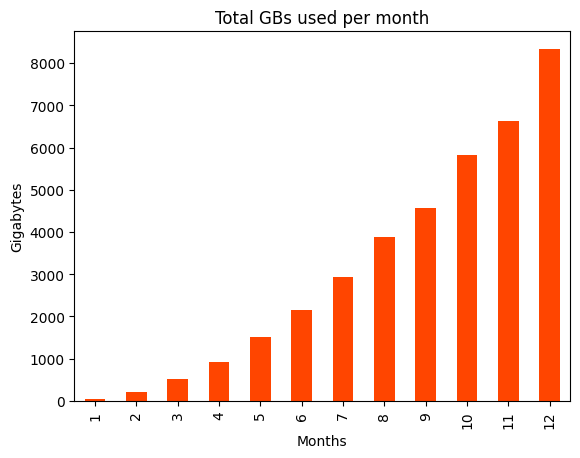

In [23]:
# Request 3
df_monthly_gbs = df_internet.groupby(['user_id','month'])['gb_used'].sum().reset_index()
internet_used = df_monthly_gbs.groupby('month')['gb_used'].sum().reset_index()

internet_used.plot(x='month',
                    y='gb_used',
                    title='Total GBs used per month',
                    xlabel='Months',
                    ylabel='Gigabytes',
                    color='orangered',
                    kind='bar',
                    legend=False,
                    )

Remarks

- A similar trend can be observed with the GB used per month.

### Income get per month

In [24]:
# Getting calls data
df_monthly_calls = df_calls.groupby(['user_id','month'])['id'].count().reset_index()
df_monthly_calls.rename(columns = {'id':'calls'},inplace=True)

# Getting minutes data
df_monthly_min_used = df_calls.groupby(['user_id','month'])['duration'].sum().reset_index()

# Creating DF
df_1 = df_monthly_calls.merge(df_monthly_min_used,how='outer')
df_2 = df_monthly_messages.merge(df_monthly_gbs,how='outer') 
df_summary = df_1.merge(df_2,how='outer')
df_summary = df_summary.merge(df_users[['user_id','plan']],how='left',on='user_id')
df_summary.rename(columns={'plan':'plan_name'},inplace=True)    #Renaming field to match df_plans field name
df_summary = df_summary.merge(df_plans.loc[:, df_plans.columns != 'mb_per_month_included'],how='left',on='plan_name')

# Filling missing data
df_summary.fillna(0,inplace=True)


# SMS
df_summary['dif_messages'] = df_summary['messages'] - df_summary['messages_included']
df_summary['dif_messages'] = df_summary['dif_messages'].apply(lambda x: max(x,0))

# Minutes
df_summary['dif_minutes'] = round(df_summary['duration'],0) - df_summary['minutes_included']
df_summary['dif_minutes'] = df_summary['dif_minutes'].apply(lambda x: max(x,0))

# Internet
df_summary['dif_gb'] = np.ceil(df_summary['gb_used'] - df_summary['gb_per_month_included'])
df_summary['dif_gb'] = df_summary['dif_gb'].apply(lambda x: max(x,0))


# Sub totals 
sub_message_income = df_summary['dif_messages'] * df_summary['usd_per_message']
sub_gb_income = df_summary['dif_gb'] * df_summary['usd_per_gb']
sub_minutes_income = df_summary['dif_minutes'] * df_summary['usd_per_minute']


# Total income
df_summary['monthly_income'] = df_summary['usd_monthly_pay'] + sub_message_income + sub_gb_income + sub_minutes_income

df_summary.head(15)

,user_id,month,calls,duration,messages,gb_used,plan_name,messages_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included,dif_messages,dif_minutes,dif_gb,monthly_income
0,1000,12,16.0,116.83,11.0,1.856904,ultimate,1000,3000,70,7,0.01,0.01,30.0,0.0,0.0,0.0,70.00
1,1001,8,27.0,171.14,30.0,6.756982,surf,50,500,20,10,0.03,0.03,15.0,0.0,0.0,0.0,20.00
2,1001,9,49.0,297.69,44.0,13.002754,surf,50,500,20,10,0.03,0.03,15.0,0.0,0.0,0.0,20.00
3,1001,10,65.0,374.11,53.0,21.807119,surf,50,500,20,10,0.03,0.03,15.0,3.0,0.0,7.0,90.09
4,1001,11,64.0,404.59,36.0,18.070605,surf,50,500,20,10,0.03,0.03,15.0,0.0,0.0,4.0,60.00
5,1001,12,56.0,392.93,44.0,18.915215,surf,50,500,20,10,0.03,0.03,15.0,0.0,0.0,4.0,60.00
6,1002,10,11.0,54.13,15.0,6.398447,surf,50,500,20,10,0.03,0.03,15.0,0.0,0.0,0.0,20.00
7,1002,11,55.0,359.76,32.0,18.891680,surf,50,500,20,10,0.03,0.03,15.0,0.0,0.0,4.0,60.00
8,1002,12,47.0,363.24,41.0,14.058828,surf,50,500,20,10,0.03,0.03,15.0,0.0,0.0,-0.0,20.00
9,1003,12,149.0,1041.00,50.0,26.410293,surf,50,500,20,10,0.03,0.03,15.0,0.0,541.0,12.0,156.23


Remarks

- We have created a new dataset to address the following questions:

## QUESTIONS

1. What is the average number of calls and minutes made per plan? 
2. What is the average number of SMS sent per plan?
3. What is the average number of GB used per plan?
4. What is the average number of income get per plan?

### Calls/minutes used per plan

In [25]:
# Creating 

def comparative_plans_bar_char(set_1,set_2,field,y_label='',color_1='blue',color_2='blue',x_label='Months',title=''):
    # Getting Dataset


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Surf's plan
    ax1.bar(set_1['month'],
            set_1[field],
            color = color_1,
            )
            
    ax1.set_title(f"Surf plan: {title}")
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)

    # Ultimate's plan
    ax2.bar(set_2['month'],
            set_2[field],
            color = color_2,
            )

    ax2.set_title(f"Ultimate plan: {title}")
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)

def comparative_plans_hist_char(set_1,set_2,field,color_1='blue',color_2='blue',x_label='',y_label='',title='',bins=30):
        # Surf's plan
        set_1[field].plot(kind = 'hist',
                        bins=bins,
                        color = color_1)

        # Ultimate's plan
        set_2[field].plot(kind = 'hist',
                        bins=bins,
                        alpha=0.8,
                        color = color_2)

        # Settings
        plt.legend(['Surf', 'Ultimate'])
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)

def basic_metrics (set_1,set_2,field,color_1='blue',color_2='blue',x_label='',y_label='Distribution'):
        set_1m = round(set_1[field].median(),2)
        set_1v = round(np.var(set_1[field]),2)

        set_2m = round(set_2[field].median(),2)
        set_2v = round(np.var(set_2[field]),2)

        # Data set structure
        data = {
                'Median':[set_1m,set_2m],
                'Var':[set_1v,set_2v]
        }
        index = ['Surf', 'Ultimate']

        # Chart settings
        plt.figure(figsize=(12, 6))

        # Surf plan
        plt.subplot(1, 2, 1)  # (filas, columnas, índice)
        sns.boxplot(x=set_1[field],
                color = color_1
        )
        plt.title('Surf Plan boxplot')
        plt.xlabel(x_label)
        plt.ylabel(y_label)

        # Ultimate plan
        plt.subplot(1, 2, 2)  # (filas, columnas, índice)
        sns.boxplot(x=set_2[field],
                color= color_2
                )
        plt.title('Ultimate Plan boxplot')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.tight_layout()

        # Showing metrics table
        print (f"Comparative metric's table: \n\n {pd.DataFrame(data,index= index)}")


#### Calls - Surf Vs Ultimate

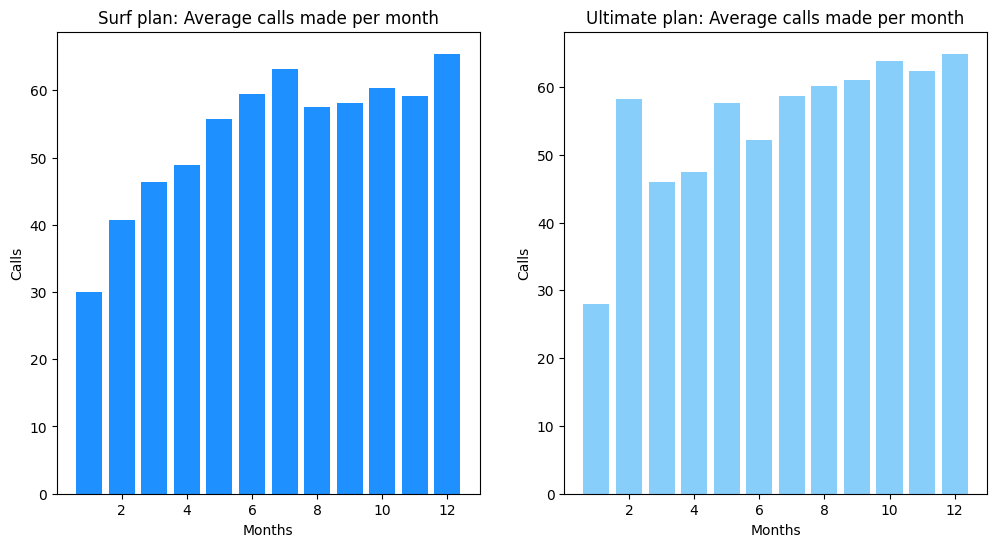

In [26]:
# Getting Dataset
calls_mean = df_summary.groupby(['month','plan_name'])['calls'].mean().reset_index()

# Plans
surf_mean_calls = calls_mean[calls_mean['plan_name'] == 'surf']
ultimate_mean_calls = calls_mean[calls_mean['plan_name'] == 'ultimate']

comparative_plans_bar_char(set_1 = surf_mean_calls,
                           color_1 = 'dodgerblue',
                           set_2 = ultimate_mean_calls,
                           color_2 = 'lightskyblue',
                           field = 'calls',
                           y_label = 'Calls',
                           title = 'Average calls made per month')

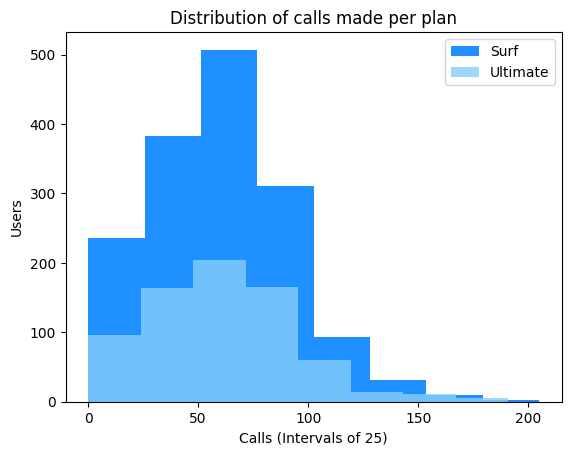

In [46]:
# Getting Dataset
calls_summary = df_summary[['plan_name','calls']] 

# Plans
surf_calls_sumary = calls_summary[calls_summary['plan_name'] == 'surf']
ultimate_calls_sumary = calls_summary[calls_summary['plan_name'] == 'ultimate']

comparative_plans_hist_char(set_1= surf_calls_sumary,
                            color_1='dodgerblue',
                            set_2 =ultimate_calls_sumary,
                            color_2='lightskyblue',
                            field ='calls',
                            x_label='Calls (Intervals of 25)',
                            y_label='Users',
                            title='Distribution of calls made per plan',
                            bins=8,
                            )

Comparative metric's table: 

           Median    Var
Surf       57.83  98.37
Ultimate   58.49  99.72


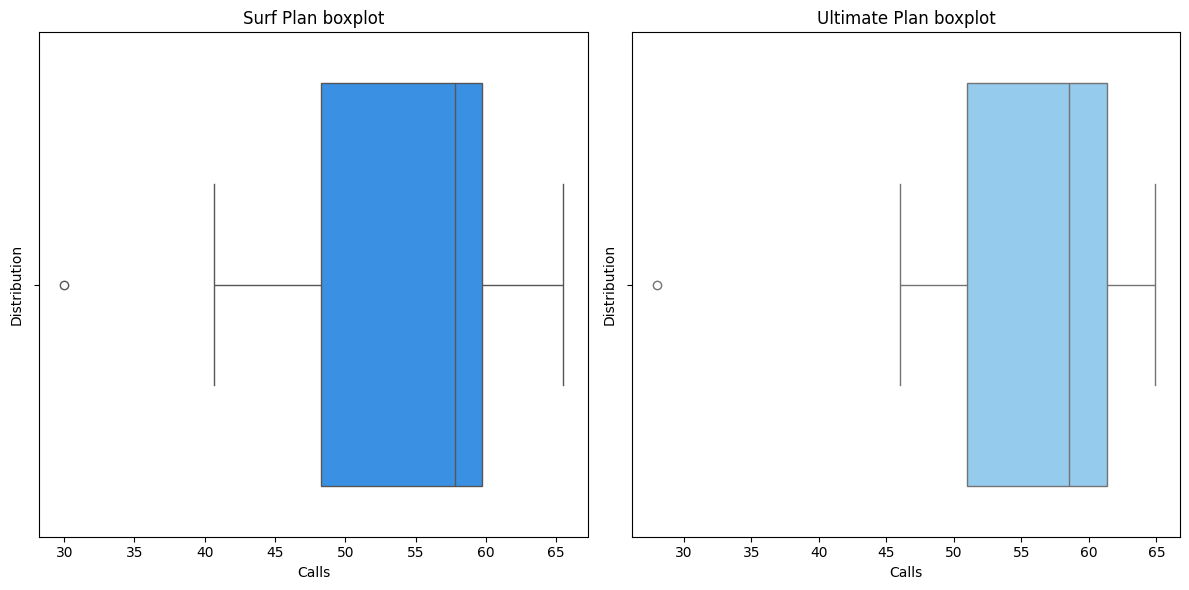

In [28]:
# Getting metric charts
basic_metrics(set_1 = surf_mean_calls,
            color_1 ='dodgerblue',
            set_2 = ultimate_mean_calls,
            color_2='lightskyblue',
            x_label = 'Calls',
            field = 'calls')

Remarks

- The call distribution for both plans is left-skewed relative to their mean values.
- The average for both plans is quite similar, around 58 calls per month.
- There is an increase in call for both plans as the months go by, with December being the highest month for both.
- The interquartile range for the Surf plan is wider than that of the Ultimate plan.

#### Minutes - Surf Vs Ultimate

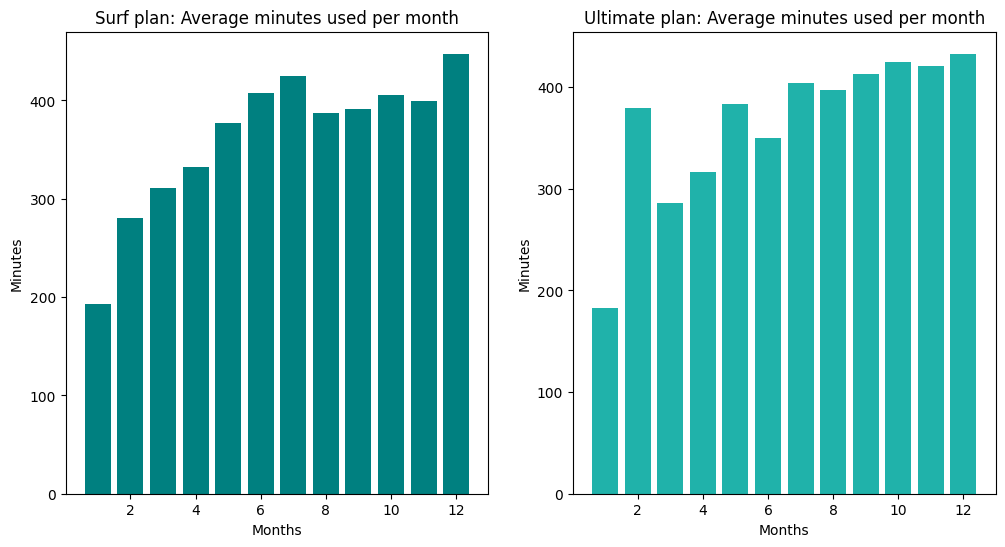

In [29]:
# Getting Dataset
minutes_mean = df_summary.groupby(['month','plan_name'])['duration'].mean().reset_index()

# Plans
surf_mean_minutes = minutes_mean[minutes_mean['plan_name'] == 'surf']
ultimate_mean_minutes = minutes_mean[minutes_mean['plan_name'] == 'ultimate']

comparative_plans_bar_char(set_1 = surf_mean_minutes,
                           color_1 = 'teal',
                           set_2 = ultimate_mean_minutes,
                           color_2 = 'lightseagreen',
                           field = 'duration',
                           y_label = 'Minutes',
                           title = 'Average minutes used per month')

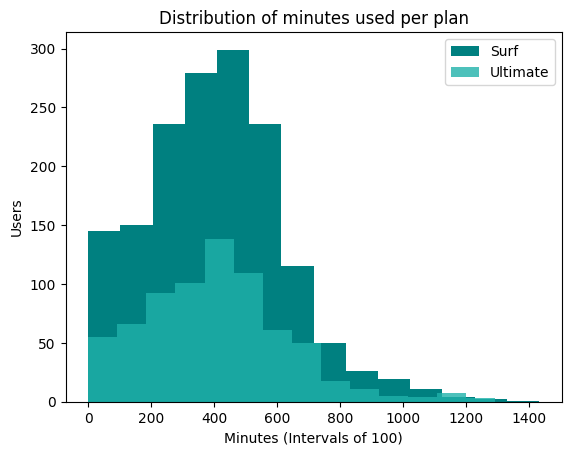

In [47]:
# Getting Dataset
minutes_summary = df_summary[['plan_name','duration']] 

# Plans
surf_minutes_sumary = minutes_summary[minutes_summary['plan_name'] == 'surf']
ultimate_minutes_sumary = minutes_summary[minutes_summary['plan_name'] == 'ultimate']

comparative_plans_hist_char(set_1= surf_minutes_sumary,
                            color_1='teal',
                            set_2 = ultimate_minutes_sumary,
                            color_2='lightseagreen',
                            field ='duration',
                            x_label='Minutes (Intervals of 100)',
                            y_label='Users',
                            title='Distribution of minutes used per plan',
                            bins=14,
                            )

Comparative metric's table: 

           Median      Var
Surf      389.08  4745.88
Ultimate  390.47  4891.08


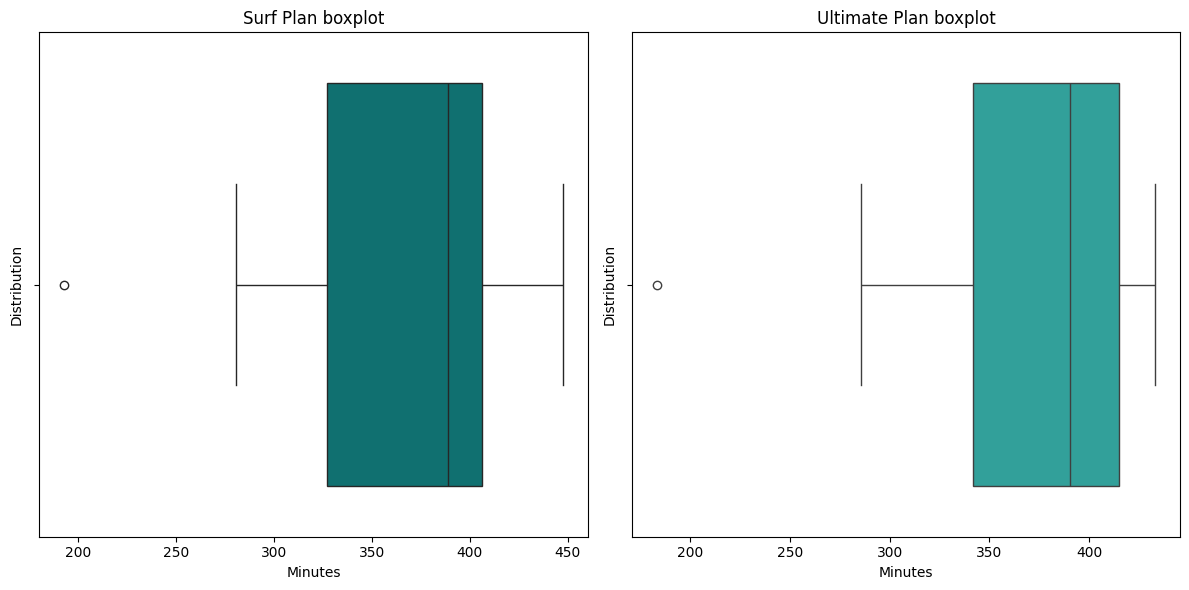

In [31]:
# Getting metric charts
basic_metrics(set_1 = surf_mean_minutes,
            color_1 ='teal',
            set_2 = ultimate_mean_minutes,
            color_2='lightseagreen',
            x_label = 'Minutes',
            field = 'duration')

Remarks

_Considering that the Surf plan includes 500 minutes and the Ultimate plan includes 3,000 minutes, the following observations were made:_

- The minutes distribution for both plans is left-skewed relative to their mean values.
- The average for both plans is quite similar, around 390 minutes per month.
- There is an increase in minutes for both plans as the months go by, with December being the highest month for both.
- Many Surf plan users exceed their 500-minute allowance, resulting in additional charges.
- None of the Ultimate plan users exceed their 3000-minute allowance.
- The interquartile range for the Surf plan is wider than that of the Ultimate plan.

### SMS sent per plan

#### SMS - Surf Vs Ultimate

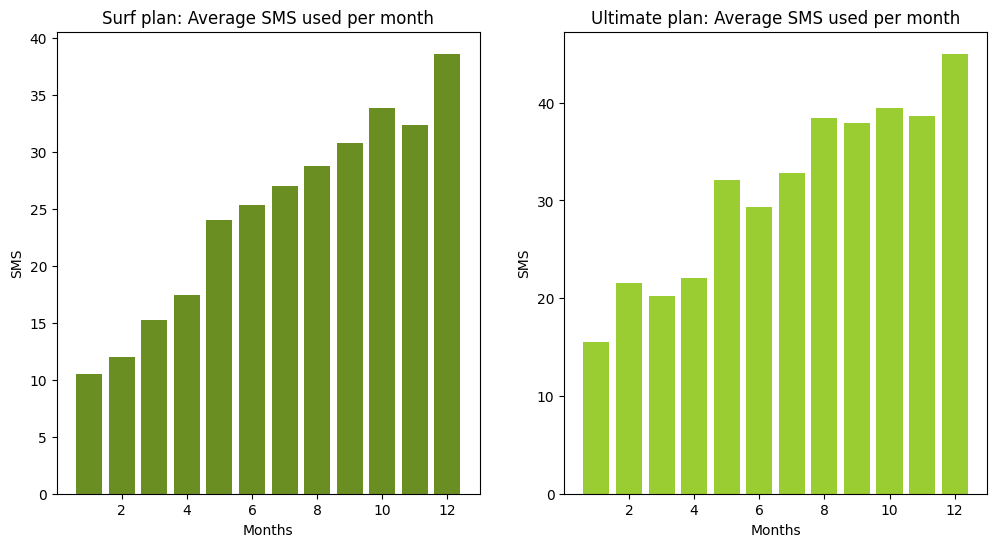

In [32]:
# Getting Dataset
messages_mean = df_summary.groupby(['month','plan_name'])['messages'].mean().reset_index()

# Plans
surf_mean_messages = messages_mean[messages_mean['plan_name'] == 'surf']
ultimate_mean_messages = messages_mean[messages_mean['plan_name'] == 'ultimate']
comparative_plans_bar_char(set_1 = surf_mean_messages,
                            color_1 = 'olivedrab',
                            set_2 = ultimate_mean_messages,
                            color_2 = 'yellowgreen',
                            field = 'messages',
                            y_label = 'SMS',
                            title = "Average SMS used per month",
)



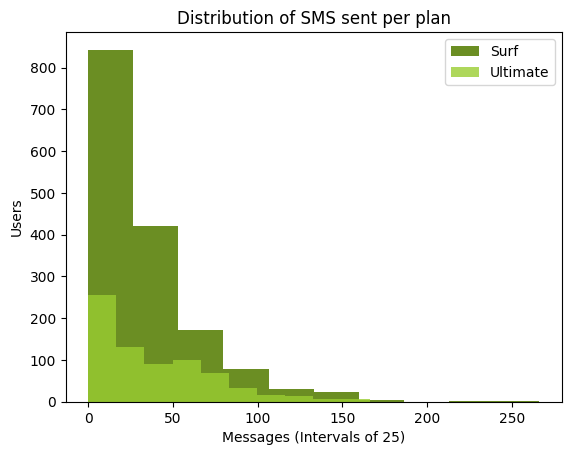

In [48]:
# Getting Dataset
message_summary = df_summary[['plan_name','messages']] 

# Plans
surf_message_sumary = message_summary[message_summary['plan_name'] == 'surf']
ultimate_message_sumary = message_summary[message_summary['plan_name'] == 'ultimate']

comparative_plans_hist_char(set_1= surf_message_sumary,
                            color_1='olivedrab',
                            set_2 = ultimate_message_sumary,
                            color_2='yellowgreen',
                            field ='messages',
                            x_label='Messages (Intervals of 25)',
                            y_label='Users',
                            title='Distribution of SMS sent per plan',
                            bins=10,
                            )

Comparative metric's table: 

           Median    Var
Surf       26.17  75.06
Ultimate   32.47  80.07


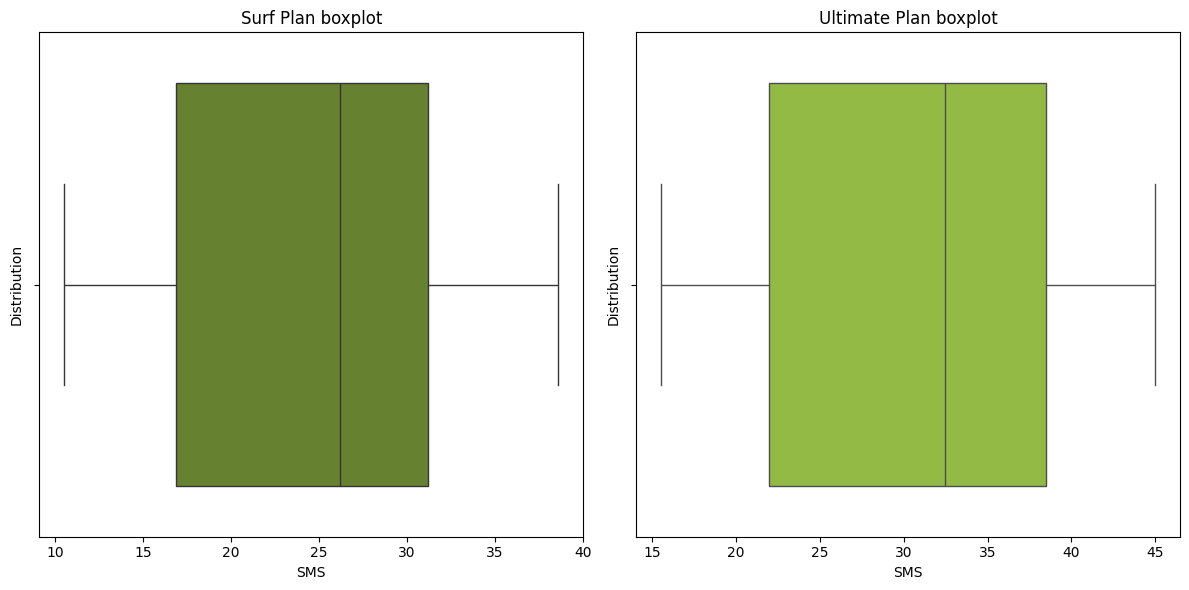

In [34]:
# Getting metric charts
basic_metrics(set_1 = surf_mean_messages,
            color_1 ='olivedrab',
            set_2 = ultimate_mean_messages,
            color_2='yellowgreen',
            x_label = 'SMS',
            field = 'messages')

Remarks

_Considering that the Surf plan includes 50 messages and the Ultimate plan includes 1,000 messages, the following observations were made:_

- The message distribution for both plans is slightly left-skewed relative to their mean values.
- The average for both plans is more spread out compared to the average of the calls.
- There is a more uniform increase in the number of messages over the months for the Surf plan, while it is more irregular for the Ultimate plan. However, December is the month with the highest number of messages for both plans.
- None of the plans exceeds the allowed message limit.
- The interquartile range is very similar for both cases.

### GB used per plan

#### GBs - Surf Vs Ultimate

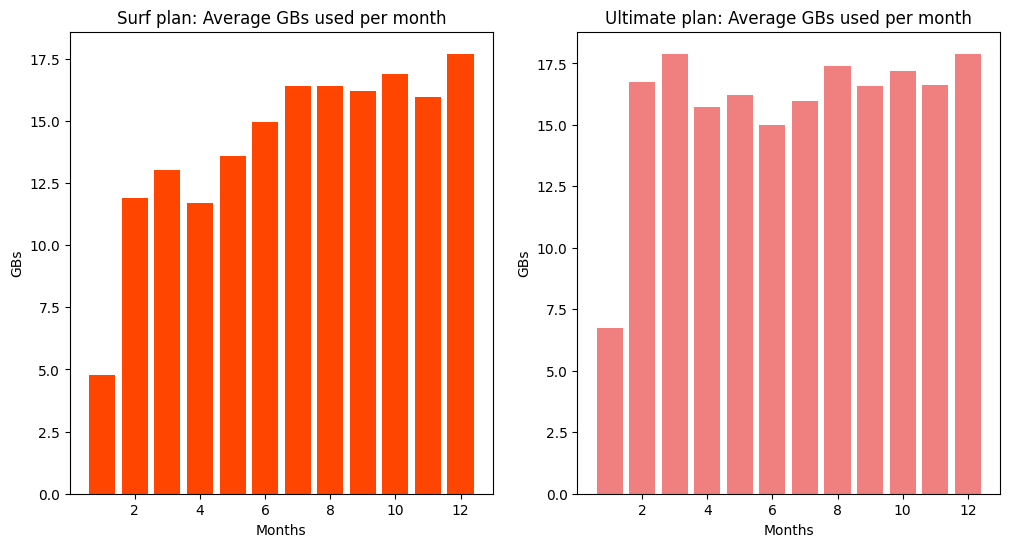

In [35]:
# Getting Dataset
gbs_mean = df_summary.groupby(['month','plan_name'])['gb_used'].mean().reset_index()

# Plans
surf_mean_gbs = gbs_mean[gbs_mean['plan_name'] == 'surf']
ultimate_mean_gbs = gbs_mean[gbs_mean['plan_name'] == 'ultimate']
comparative_plans_bar_char(set_1 = surf_mean_gbs,
                            color_1 = 'orangered',
                            set_2 = ultimate_mean_gbs,
                            color_2 = 'lightcoral',
                            field = 'gb_used',
                            y_label = 'GBs',
                            title = "Average GBs used per month",
)

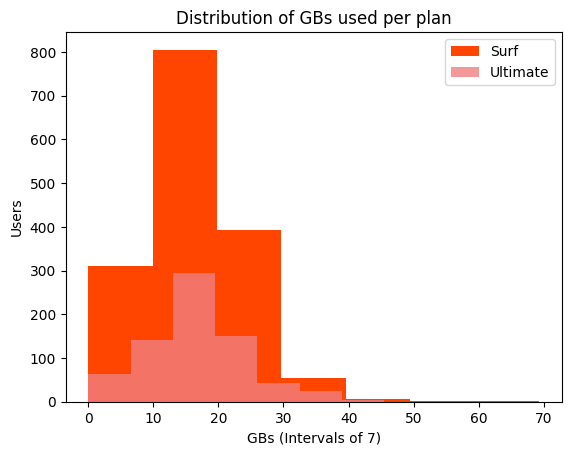

In [49]:
# Getting Dataset
gbs_summary = df_summary[['plan_name','gb_used']] 

# Plans
surf_gbs_sumary = gbs_summary[gbs_summary['plan_name'] == 'surf']
ultimate_gbs_sumary = gbs_summary[gbs_summary['plan_name'] == 'ultimate']

comparative_plans_hist_char(set_1= surf_gbs_sumary,
                            color_1='orangered',
                            set_2 = ultimate_gbs_sumary,
                            color_2='lightcoral',
                            field ='gb_used',
                            x_label='GBs (Intervals of 7)',
                            y_label='Users',
                            title='Distribution of GBs used per plan',
                            bins=7,
                            )

Comparative metric's table: 

           Median    Var
Surf       15.45  11.60
Ultimate   16.60   8.17


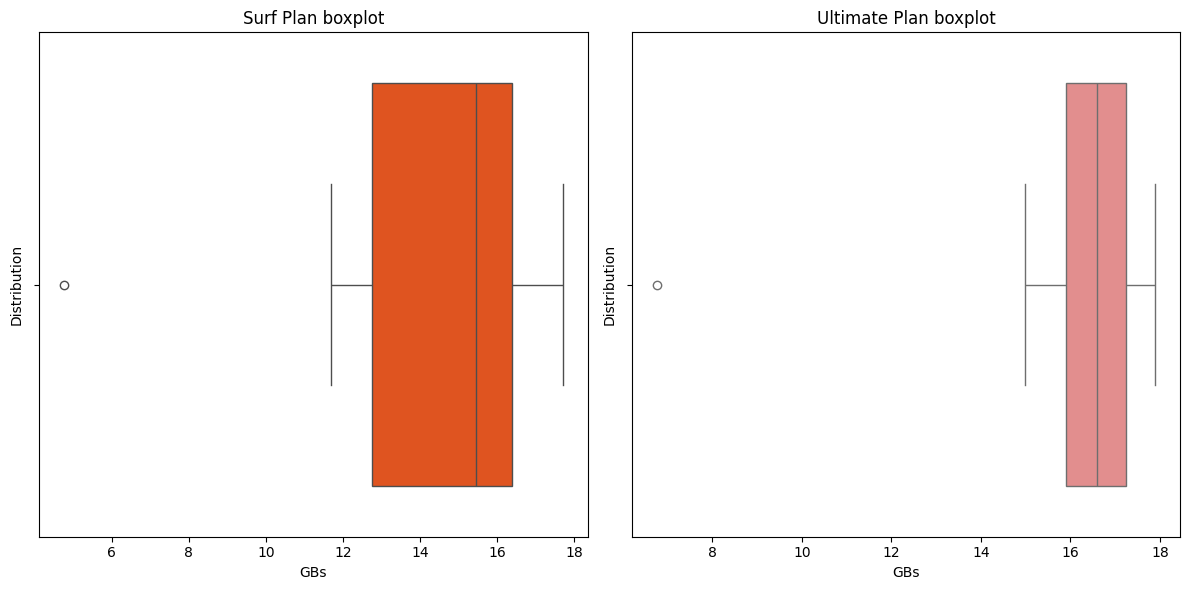

In [37]:
# Getting metric charts
basic_metrics(set_1 = surf_mean_gbs,
            color_1 ='orangered',
            set_2 = ultimate_mean_gbs,
            color_2='lightcoral',
            x_label = 'GBs',
            field = 'gb_used')

Remarks

_Considering that the Surf plan offers 15GB and the Ultimate plan offers 30GB, the following observations were made:_

- The distribution of GB usage for the Surf plan is left-skewed and has greater dispersion among its data.
- The distribution of GB usage for the Ultimate plan is slightly left-skewed, with less data dispersion.
- The average for both plans is pretty similar.
- There is an upward trend in data consumption for the Surf plan as the months progress, with December being the month with the highest average data usage.
- The Ultimate plan maintains relatively consistent data usage throughout the year, with the highest consumption occurring in March and December.
- On average, Surf plan users do not exceed their monthly data limit, while Ultimate plan users do not exceed their allowance.

### Income get per plan

#### Income - Surf Vs Ultimate

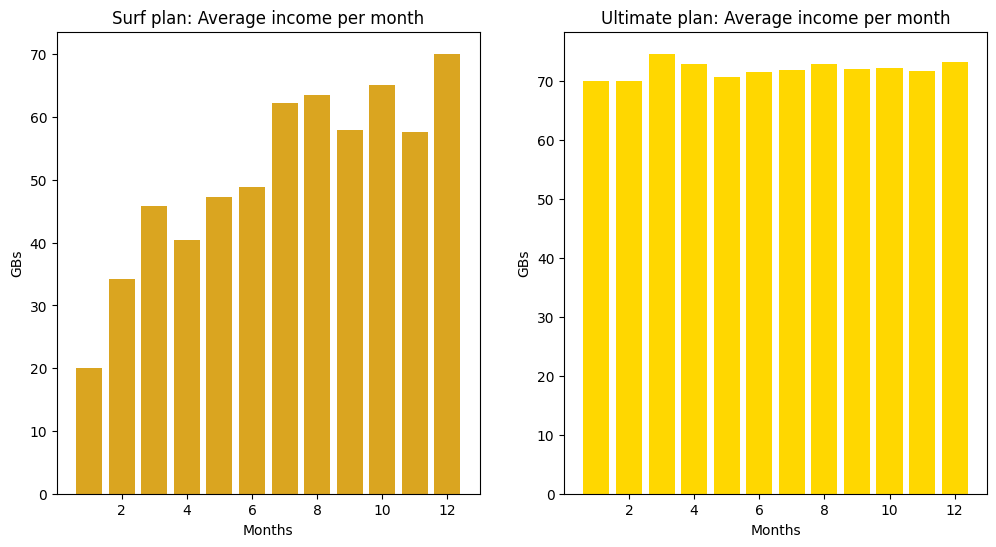

In [38]:
# Getting Dataset
income_mean = df_summary.groupby(['month','plan_name'])['monthly_income'].mean().reset_index()

# Plans
surf_mean_income = income_mean[income_mean['plan_name'] == 'surf']
ultimate_mean_income = income_mean[income_mean['plan_name'] == 'ultimate']

comparative_plans_bar_char(set_1 = surf_mean_income,
                            color_1 = 'goldenrod',
                            set_2 = ultimate_mean_income,
                            color_2 = 'gold',
                            field = 'monthly_income',
                            y_label = 'GBs',
                            title = "Average income per month",
)

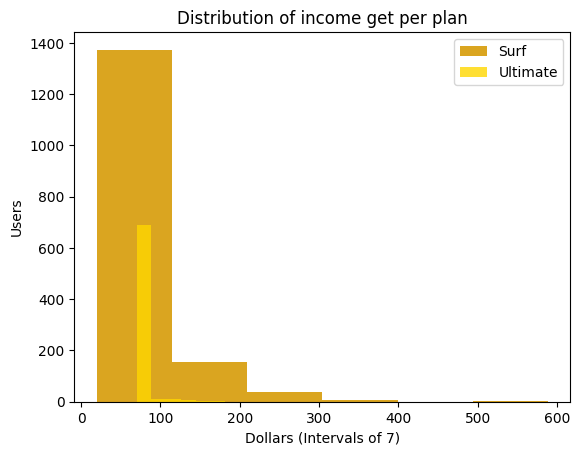

In [50]:
# Getting Dataset
income_summary = df_summary[['plan_name','monthly_income']] 

# Plans
surf_income_sumary = income_summary[income_summary['plan_name'] == 'surf']
ultimate_income_sumary = income_summary[income_summary['plan_name'] == 'ultimate']

comparative_plans_hist_char(set_1= surf_income_sumary,
                            color_1='goldenrod',
                            set_2 = ultimate_income_sumary,
                            color_2='gold',
                            field ='monthly_income',
                            x_label='Dollars (Intervals of 7)',
                            y_label='Users',
                            title='Distribution of income get per plan',
                            bins=6,
                            )

Comparative metric's table: 

           Median     Var
Surf       53.28  194.71
Ultimate   71.97    1.71


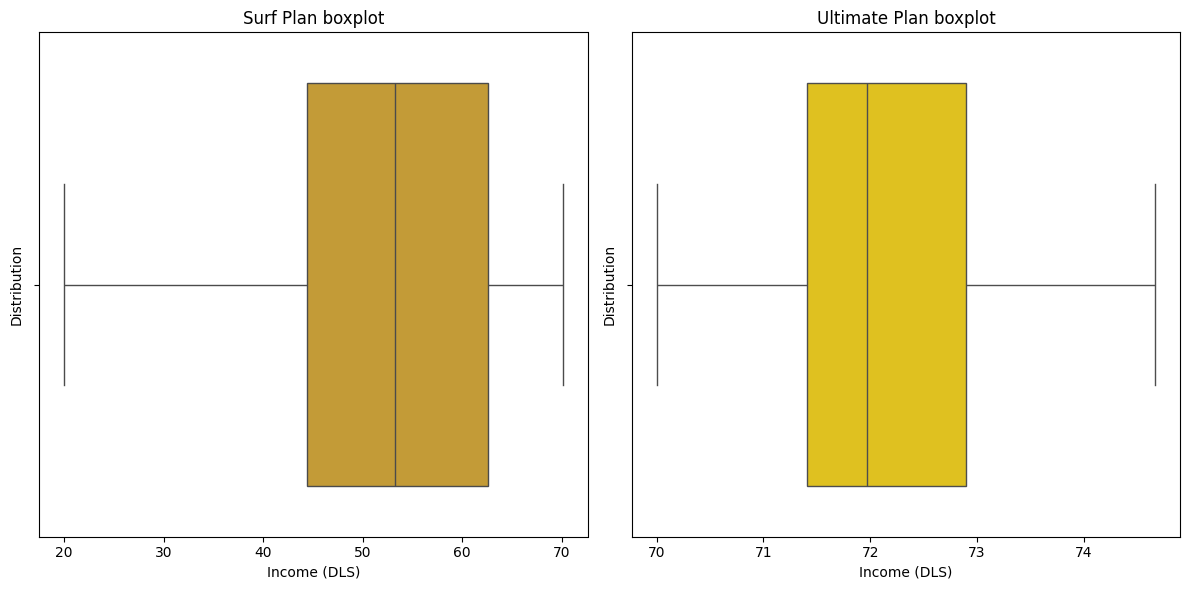

In [40]:
# Getting metric charts
basic_metrics(set_1 = surf_mean_income,
            color_1 ='goldenrod',
            set_2 = ultimate_mean_income,
            color_2='gold',
            x_label = 'Income (DLS)',
            field = 'monthly_income')

Remarks

_Considering that the Surf plan costs $20 and the Ultimate plan costs $70, the following observations were made_

- The distribution of Surf plan revenues is slightly righ-skewed.
- The distribution of Ultimate plan revenues is right-skewed.
- The Surf plan has greater revenue dispersion.
- The Ultimate plan has lower revenue dispersion.
- Surf plan users pay more over the months, with December being the month where they pay, on average, three times the package cost.
- Most Ultimate plan users generally stay close to the $70 mark, with March being the month with the highest average revenue.
- The interquartile range for the Surf plan is much larger than for the Ultimate plan.

## HYPOTHESIS

In [41]:
# Test the Hypothesis
# Equality of the means of two populations
# Null Hypothesis (H₀): The average income of both plans does not change.
# Alternative Hypothesis (H₁): The average income of both plans is different.

alpha = 0.05

results = st.ttest_ind(ultimate_mean_income['monthly_income'], surf_mean_income['monthly_income'], equal_var = False) 

print('valor p: ', results.pvalue, '\n')

# Testing Null Hypothesis
if results.pvalue < alpha:
    print("We reject the null hypothesis: The average income of both plans does not change. ")
else:
    print("We fail to reject the null hypothesis: The average income of both plans does not change.")

valor p:  0.00041442906078868893 

We reject the null hypothesis: The average income of both plans does not change. 


In [42]:
# Prueba las hipótesis

# Null Hypothesis (H₀): The average income of NY-NJ is the same as that of other cities.
# Alternative Hypothesis (H₁): The average income of NY-NJ is different from that of other cities.
# NEW YORK-NEWARK-JERSEY CITY, NY-NJ-PA MSA - 49.329515


def ny_nj_vs_other_cities(city_name,df):
    alpha = 0.05
    
    # Getting Dataset
    ny_nj_mean = df.groupby('city')['monthly_income'].mean().reset_index()

    # Getting income for NY-NJ
    ny_nj_mean = ny_nj_mean[ny_nj_mean['city'] == 'NEW YORK-NEWARK-JERSEY CITY, NY-NJ-PA MSA']['monthly_income'].values

     # Getting income for city to compare
    other_city = df[df['city'] == city_name]['monthly_income']


    results = st.ttest_1samp (other_city, ny_nj_mean)
    
    # Testing Null Hypothesis
    if (results.pvalue < alpha):
        return print('valor p: ', results.pvalue , '\n') , print("We reject the null hypothesis: 'The average income of NY-NJ is equal to that of the city' >>", city_name)
    else:
        return print('valor p: ', results.pvalue, '\n') , print("We fail to reject the null hypothesis: 'The average income of NY-NJ is equal to that of the city' >>", city_name)

In [43]:
#Unimos a nuestro data frame summary las ciudades del df_users
df_summary_city = df_summary.merge(df_users[['user_id','city']],on='user_id',how='left')

#Mostramos una lista aleatoria de 5 ciudades para poder extraer el nombre y probar nuestra funcion
city_mean = df_summary_city.groupby('city')['monthly_income'].mean().reset_index()
city_mean.sample(5)

,city,monthly_income
70,"URBAN HONOLULU, HI MSA",112.402381
65,"ST. LOUIS, MO-IL MSA",79.142727
23,"DETROIT-WARREN-DEARBORN, MI MSA",51.127500
53,"PROVIDENCE-WARWICK, RI-MA MSA",82.195455
60,"SAN ANTONIO-NEW BRAUNFELS, TX MSA",70.331176


In [44]:
#Probamos nuestra funcion con cada cicudad que queramos
city = 'AUSTIN-ROUND ROCK-GEORGETOWN, TX MSA'
ny_nj_vs_other_cities(city,df_summary_city)

valor p:  0.6744676785723875 

We fail to reject the null hypothesis: 'The average income of NY-NJ is equal to that of the city' >> AUSTIN-ROUND ROCK-GEORGETOWN, TX MSA


(None, None)

Remarks

_Returning to the initial question: Which is the best plan? We can conclude that..._

- Users with the Surf plan should not switch to the Ultimate plan, as they would spend at least $70 on average per month with the Ultimate plan. Even if Surf plan users exceed their limits for calls, MB, and messages, they still pay less than Ultimate plan users.
- The months closest to December are when the company earns the most from the Surf plan, while the revenue flow for the Ultimate plan is more stable throughout the year.
- When comparing the plans, it is noticeable that there are more users on the Surf plan than on the Ultimate plan. However, the Ultimate plan generates higher revenue with-  fewer users.
- In general, it is more beneficial for users to choose the Surf plan.
- Meanwhile, the company should consider promotional strategies to encourage more people to switch to the Ultimate plan, thereby generating more revenue